#About This Project
### In this project, our task is to build and train a model to recognize opinions expressed in a sentence. This is an LSTM multi-class (positive, negative, neutral) classification problem.

##Sentiment Analysis


#Implementation

## Importing libraries

In [ ]:
!nvidia-smi

Thu Jul 14 06:09:31 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   70C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import numpy as np 
import pandas as pd 

import tqdm, os, gc, subprocess, zipfile, gdown, pickle

from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.layers import Dense, LSTM, GRU, SimpleRNN 
from keras.layers import Embedding, Dropout, Activation, Input
from keras.models import Model
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, Input
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical

import re
import gc
from sklearn.model_selection import train_test_split
import sklearn.model_selection as model_selection
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
import seaborn as sns
sns.set_style("dark")
sns.set(font_scale=1)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Read  train data file

In [ ]:
data  = pd.read_excel('/content/drive/MyDrive/Data-mining/Labeled-Sentences.xlsx')
data = data[['text','sentiment']]
print()

In [ ]:
print('Positive:',data[ data['sentiment'] == 'Positive'].size /2)
print('Negative:',data[ data['sentiment'] == 'Negative'].size/2)
print('Neutral:',data[ data['sentiment'] == 'Neutral'].size/2)


Positive: 1203.0
Negative: 264.0
Neutral: 166.0


پیش پردازش ها

In [ ]:
max_features = 70000
tokenizer = Tokenizer(num_words=max_features, split=' ')
tokenizer.fit_on_texts((data['text'].values).astype(str))
X = tokenizer.texts_to_sequences((data['text'].values).astype(str))
y = np.array(pd.get_dummies(data['sentiment']))

# recognize suitable padding for sentences
      

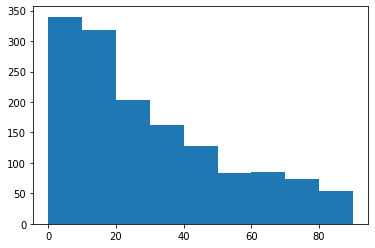

In [ ]:
totalNumWords = [len(one_comment) for one_comment in X]
plt.hist(totalNumWords,bins = np.arange(0,100,10))
plt.show()

همه جملات را به طول 300 میرسانیم

In [ ]:
maxlen = 300
X = pad_sequences(X, maxlen)
X = np.array(X)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=4)

##  load our embeddings model into a dictionary 

In [ ]:
def loadEmbeddingMatrix(typeToLoad):
        #load different embedding file from Kaggle depending on which embedding 
        #matrix we are going to experiment with
    if(typeToLoad=="glove"):
        EMBEDDING_FILE='/content/drive/MyDrive/Data-mining/vectors.txt'
        embed_size = 300
    
    if(typeToLoad=="glove" or typeToLoad=="fasttext" ):
        embeddings_index = dict()
            #Transfer the embedding weights into a dictionary by iterating through every line of the file.
        with open(EMBEDDING_FILE,'r', encoding='utf8')as f:
            for line in f:
                try:
                    values = line.split()

                    if len(values)==301:
                        word = values[0]    
                        coefs = np.asarray(values[1:], dtype='float32')
                        embeddings_index[word] = coefs
                    elif len(values)==302:
          #print(len(value))
                        word = values[0]+'\u200c'+values[1]   
                        coefs = np.asarray(values[2:], dtype='float32')
                        embeddings_index[word] = coefs
                    elif len(values)==303:
                        word = values[0]+'\u200c'+values[1]+'\u200c'+values[2]  
                        coefs = np.asarray(values[3:], dtype='float32')
                        embeddings_index[word] = coefs
                except Exception as inst:
                        print(inst)

            
    gc.collect()
        #We get the mean and standard deviation of the embedding weights so that we could maintain the 
        #same statistics for the rest of our own random generated weights. 
    all_embs = np.stack(list(embeddings_index.values()))
    emb_mean,emb_std = all_embs.mean(), all_embs.std()
        
    nb_words = len(tokenizer.word_index) + 1
        #We are going to set the embedding size to the pretrained dimension as we are replicating it.
        #the size will be Number of Words in Vocab X Embedding Size
    embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
    gc.collect()

        #With the newly created embedding matrix, we'll fill it up with the words that we have in both 
        #our own dictionary and loaded pretrained embedding. 
    embeddedCount = 0
    embedding_matrix[0] = 0
    for word, i in tokenizer.word_index.items():
            #then we see if this word is in glove's dictionary, if yes, get the corresponding weights
            embedding_vector = embeddings_index.get(word)
            #and store inside the embedding matrix that we will train later on.
            if embedding_vector is not None: 
                embedding_matrix[i] = embedding_vector
                embeddedCount+=1
    print('total embedded:',embeddedCount,'common words')
        
    del(embeddings_index)
    gc.collect()
        
        #finally, return the embedding matrix
    return embedding_matrix

In [ ]:
def showacc():
  loss_train = history.history['loss']
  loss_val = history.history['val_loss']
  acc_train = history.history['accuracy']
  acc_val = history.history['val_accuracy']
  epochs = range(1,6)
  #plt.plot(epochs, loss_train, 'g', label='Training loss')
  #plt.plot(epochs, loss_val, 'b', label='validation loss')
  plt.plot(epochs, acc_train, 'r', label='Training accuracy')
  plt.plot(epochs, acc_val, 'b', label='validation accuracy')
  plt.title('Training and Validation Accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.show()

def showloss():
  loss_train = history.history['loss']
  loss_val = history.history['val_loss']
  acc_train = history.history['accuracy']
  acc_val = history.history['val_accuracy']
  epochs = range(1,6)
  plt.plot(epochs, loss_train, 'g', label='Training loss')
  plt.plot(epochs, loss_val, 'b', label='validation loss')
  #plt.plot(epochs, acc_train, 'r', label='Training accuracy')
  #plt.plot(epochs, acc_val, 'b', label='validation accuracy')
  plt.title('Training and Validation loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

##First one layer LSTM


## **Bidirectional LSTM model with GloVe pretrain**

In [ ]:
embedding_matrix = loadEmbeddingMatrix('glove')

total embedded: 3449 common words


In [ ]:
model = Sequential()
model.add(Embedding(len(tokenizer.word_index)+1, embedding_matrix.shape[1],weights=[embedding_matrix], input_length=maxlen))
model.add(Dropout(0.1))
model.add(Bidirectional(LSTM(32, dropout=0.1, recurrent_dropout=0.1 , return_sequences=True)))
model.add(GlobalMaxPool1D())
model.add(Dropout(0.1))

model.add(Dense(32, activation="relu"))
model.add(Dropout(0.1))

model.add(Dense(3, activation="softmax"))

model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

epochs = 5
batch_size = 64
history=model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,validation_data=(X_test, y_test),verbose=2)


Epoch 1/5
21/21 - 54s - loss: 0.9137 - accuracy: 0.6646 - val_loss: 0.8109 - val_accuracy: 0.7278 - 54s/epoch - 3s/step
Epoch 2/5
21/21 - 50s - loss: 0.7588 - accuracy: 0.7389 - val_loss: 0.7617 - val_accuracy: 0.7278 - 50s/epoch - 2s/step
Epoch 3/5
21/21 - 49s - loss: 0.7143 - accuracy: 0.7389 - val_loss: 0.7160 - val_accuracy: 0.7278 - 49s/epoch - 2s/step
Epoch 4/5
21/21 - 49s - loss: 0.6247 - accuracy: 0.7443 - val_loss: 0.6111 - val_accuracy: 0.7523 - 49s/epoch - 2s/step
Epoch 5/5
21/21 - 50s - loss: 0.4597 - accuracy: 0.8239 - val_loss: 0.5914 - val_accuracy: 0.7401 - 50s/epoch - 2s/step


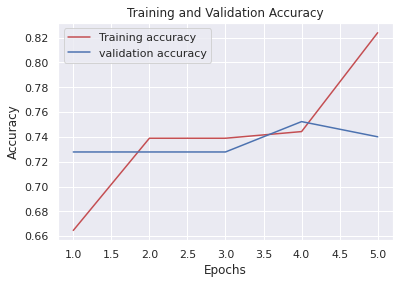

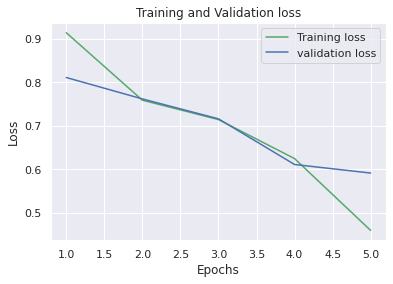

In [ ]:
showacc()
showloss()

## **LSTM model with GloVe pretrain**

In [ ]:
embedding_matrix = loadEmbeddingMatrix('glove')

total embedded: 3449 common words


In [ ]:
inp = Input(shape=(maxlen, ))
model = Sequential()
model.add(Embedding(len(tokenizer.word_index)+1, embedding_matrix.shape[1],weights=[embedding_matrix], input_length=maxlen))


model.add(LSTM(32,name='lstm_layer',dropout=0.2,recurrent_dropout=0.2, return_sequences=True))
model.add(GlobalMaxPool1D())

model.add(Dense(32, activation="relu"))
model.add(Dropout(0.1))

model.add(Dense(3, activation="softmax"))

model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

epochs = 5
batch_size = 256

history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size ,validation_data=(X_test, y_test),verbose=2)


Epoch 1/5
6/6 - 11s - loss: 1.0551 - accuracy: 0.3920 - val_loss: 0.9845 - val_accuracy: 0.7370 - 11s/epoch - 2s/step
Epoch 2/5
6/6 - 8s - loss: 0.9424 - accuracy: 0.6975 - val_loss: 0.8981 - val_accuracy: 0.7278 - 8s/epoch - 1s/step
Epoch 3/5
6/6 - 8s - loss: 0.8489 - accuracy: 0.7366 - val_loss: 0.8293 - val_accuracy: 0.7278 - 8s/epoch - 1s/step
Epoch 4/5
6/6 - 8s - loss: 0.7882 - accuracy: 0.7389 - val_loss: 0.8001 - val_accuracy: 0.7278 - 8s/epoch - 1s/step
Epoch 5/5
6/6 - 8s - loss: 0.7527 - accuracy: 0.7389 - val_loss: 0.7795 - val_accuracy: 0.7278 - 8s/epoch - 1s/step


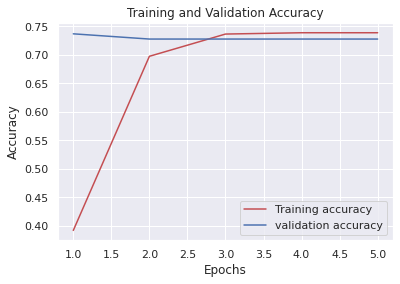

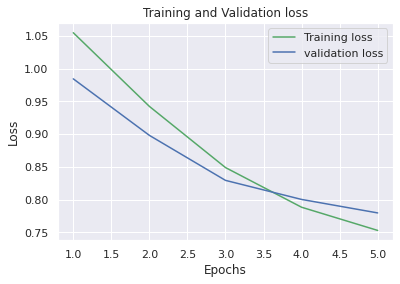

In [ ]:
showacc()
showloss()

## LSTM model without pretrain

In [ ]:
model = Sequential()
model.add(Embedding(len(tokenizer.word_index)+1, embedding_matrix.shape[1], input_length=maxlen))
model.add(Dropout(0.1))
model.add(LSTM(32,name='lstm_layer',dropout=0.2,recurrent_dropout=0.2, return_sequences=True))
model.add(GlobalMaxPool1D())

model.add(Dense(32, activation="relu"))
model.add(Dropout(0.1))

model.add(Dense(3, activation="softmax"))

model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])


epochs = 5
batch_size = 256

model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size ,validation_data=(X_test, y_test),verbose=2)


Epoch 1/5
6/6 - 11s - loss: 1.0366 - accuracy: 0.7152 - val_loss: 0.9518 - val_accuracy: 0.7278 - 11s/epoch - 2s/step
Epoch 2/5
6/6 - 8s - loss: 0.8536 - accuracy: 0.7389 - val_loss: 0.7968 - val_accuracy: 0.7278 - 8s/epoch - 1s/step
Epoch 3/5
6/6 - 8s - loss: 0.7604 - accuracy: 0.7389 - val_loss: 0.7681 - val_accuracy: 0.7278 - 8s/epoch - 1s/step
Epoch 4/5
6/6 - 8s - loss: 0.7589 - accuracy: 0.7389 - val_loss: 0.7695 - val_accuracy: 0.7278 - 8s/epoch - 1s/step
Epoch 5/5
6/6 - 8s - loss: 0.7533 - accuracy: 0.7389 - val_loss: 0.7626 - val_accuracy: 0.7278 - 8s/epoch - 1s/step


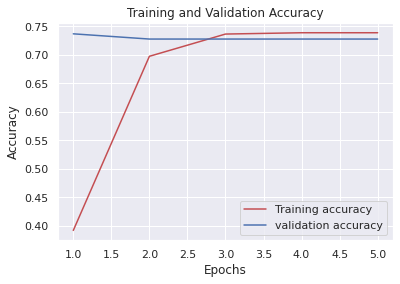

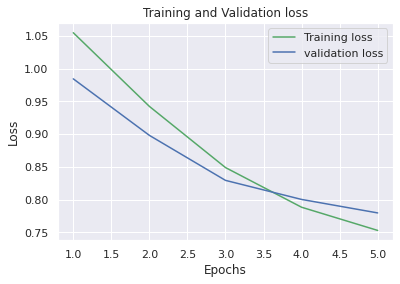

In [ ]:
showacc()
showloss()

##  Bidirectional LSTM model without pretrain

In [ ]:
model = Sequential()
model.add(Embedding(len(tokenizer.word_index)+1, embedding_matrix.shape[1], input_length=maxlen))
model.add(Dropout(0.1))
model.add(Bidirectional(LSTM(32, dropout=0.1, recurrent_dropout=0.1 , return_sequences=True)))
model.add(GlobalMaxPool1D())
model.add(Dropout(0.1))

model.add(Dense(32, activation="relu"))
model.add(Dropout(0.1))

model.add(Dense(3, activation="softmax"))

model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

epochs = 5
batch_size = 256

history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,validation_data=(X_test, y_test))


Epoch 1/5
6/6 [==============================] - 71s 3s/step - loss: 1.0353 - accuracy: 0.6371 - val_loss: 0.9238 - val_accuracy: 0.7278
Epoch 2/5
6/6 [==============================] - 16s 3s/step - loss: 0.8392 - accuracy: 0.7389 - val_loss: 0.7738 - val_accuracy: 0.7278
Epoch 3/5
6/6 [==============================] - 15s 3s/step - loss: 0.7535 - accuracy: 0.7389 - val_loss: 0.7718 - val_accuracy: 0.7278
Epoch 4/5
6/6 [==============================] - 15s 3s/step - loss: 0.7560 - accuracy: 0.7389 - val_loss: 0.7546 - val_accuracy: 0.7278
Epoch 5/5
6/6 [==============================] - 15s 3s/step - loss: 0.7306 - accuracy: 0.7389 - val_loss: 0.7490 - val_accuracy: 0.7278


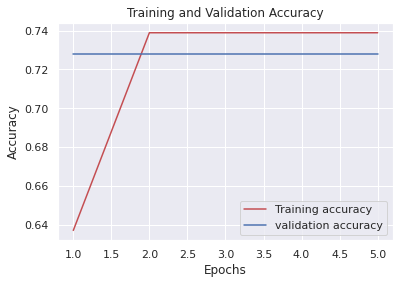

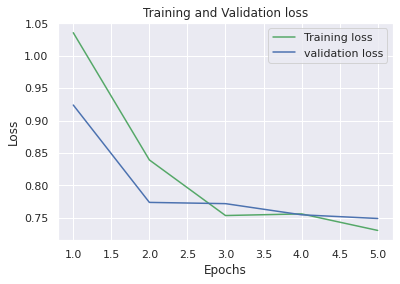

In [ ]:
showacc()
showloss()

# **2STACK LSTM with glove**

In [ ]:
model = Sequential()
model.add(Input(shape=(maxlen, )))
model.add(Embedding(len(tokenizer.word_index)+1, embedding_matrix.shape[1],weights=[embedding_matrix],trainable=False, mask_zero=True))

model.add(LSTM(32,name='lstm_layer_1',dropout=0.2,recurrent_dropout=0.2, return_sequences=True,  activation='tanh'))
model.add(LSTM(32,name='lstm_layer_2',dropout=0.2,recurrent_dropout=0.2, return_sequences=True, activation='tanh'))

model.add(GlobalMaxPool1D())

model.add(Dense(32, activation="relu"))
model.add(Dropout(0.1))

model.add(Dense(3, activation="softmax"))

model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
epochs = 5
batch_size = 256

history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size ,validation_data=(X_test, y_test),verbose=2)

Epoch 1/5
6/6 - 22s - loss: 1.0978 - accuracy: 0.4158 - val_loss: 1.0688 - val_accuracy: 0.7278 - 22s/epoch - 4s/step
Epoch 2/5
6/6 - 16s - loss: 1.0506 - accuracy: 0.7381 - val_loss: 1.0173 - val_accuracy: 0.7278 - 16s/epoch - 3s/step
Epoch 3/5
6/6 - 17s - loss: 0.9753 - accuracy: 0.7389 - val_loss: 0.9213 - val_accuracy: 0.7278 - 17s/epoch - 3s/step
Epoch 4/5
6/6 - 17s - loss: 0.8816 - accuracy: 0.7389 - val_loss: 0.8468 - val_accuracy: 0.7278 - 17s/epoch - 3s/step
Epoch 5/5
6/6 - 17s - loss: 0.8252 - accuracy: 0.7389 - val_loss: 0.8129 - val_accuracy: 0.7278 - 17s/epoch - 3s/step


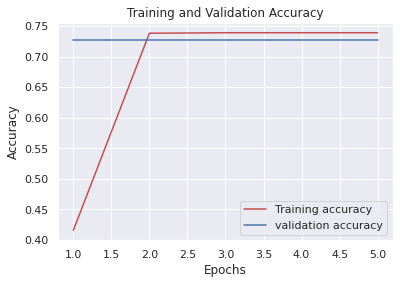

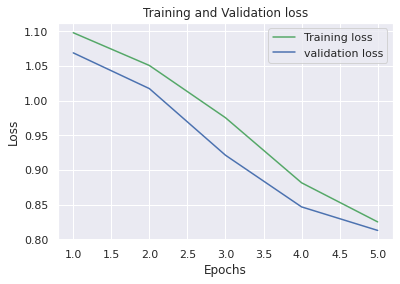

In [ ]:
showacc()
showloss()

# **4STACK LSTM with glove**

In [ ]:
inp = Input(shape=(maxlen, ))
model = Sequential()
model.add(Embedding(len(tokenizer.word_index)+1, embedding_matrix.shape[1],weights=[embedding_matrix], input_length=maxlen))
model.add(Dropout(0.1))
model.add(LSTM(60, dropout=0.1, recurrent_dropout=0.1, return_sequences = True))
model.add(Dropout(0.1))
model.add(LSTM(60, dropout=0.1, recurrent_dropout=0.1, return_sequences = True))
model.add(Dropout(0.1))
model.add(LSTM(60, dropout=0.1, recurrent_dropout=0.1, return_sequences = True))
model.add(Dropout(0.1))
model.add(LSTM(60, dropout=0.1, recurrent_dropout=0.1))
model.add(Dropout(0.1))
model.add(Dense(3, activation="softmax"))
model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

epochs = 5
batch_size = 64

history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size ,validation_data=(X_test, y_test),verbose=2)


Epoch 1/5
21/21 - 109s - loss: 0.8503 - accuracy: 0.7190 - val_loss: 0.7502 - val_accuracy: 0.7278 - 109s/epoch - 5s/step
Epoch 2/5
21/21 - 99s - loss: 0.6663 - accuracy: 0.7626 - val_loss: 0.6513 - val_accuracy: 0.7584 - 99s/epoch - 5s/step
Epoch 3/5
21/21 - 98s - loss: 0.5016 - accuracy: 0.8231 - val_loss: 0.6138 - val_accuracy: 0.7859 - 98s/epoch - 5s/step
Epoch 4/5
21/21 - 100s - loss: 0.3816 - accuracy: 0.8560 - val_loss: 0.6932 - val_accuracy: 0.7554 - 100s/epoch - 5s/step
Epoch 5/5
21/21 - 99s - loss: 0.2926 - accuracy: 0.8974 - val_loss: 0.7309 - val_accuracy: 0.7217 - 99s/epoch - 5s/step


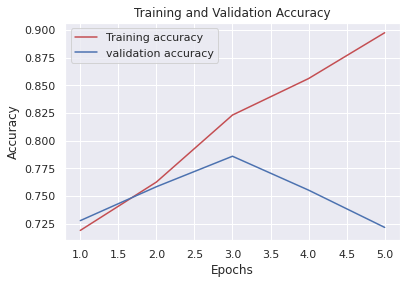

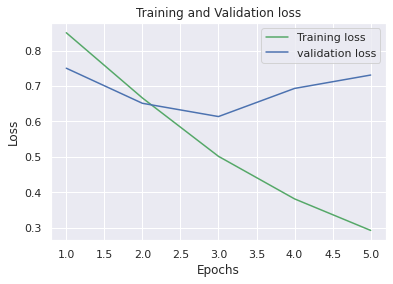

In [ ]:
showacc()
showloss()

# **6STACK LSTM with glove**

In [ ]:
inp = Input(shape=(maxlen, ))
model = Sequential()
model.add(Embedding(len(tokenizer.word_index)+1, embedding_matrix.shape[1],weights=[embedding_matrix], input_length=maxlen))
model.add(Dropout(0.1))
model.add(LSTM(60, dropout=0.1, recurrent_dropout=0.1, return_sequences = True))
model.add(Dropout(0.1))
model.add(LSTM(60, dropout=0.1, recurrent_dropout=0.1, return_sequences = True))
model.add(Dropout(0.1))
model.add(LSTM(60, dropout=0.1, recurrent_dropout=0.1, return_sequences = True))
model.add(Dropout(0.1))
model.add(LSTM(60, dropout=0.1, recurrent_dropout=0.1, return_sequences = True))
model.add(Dropout(0.1))
model.add(LSTM(60, dropout=0.1, recurrent_dropout=0.1, return_sequences = True))
model.add(Dropout(0.1))
model.add(LSTM(60, dropout=0.1, recurrent_dropout=0.1))
model.add(Dropout(0.1))
model.add(Dense(3, activation="softmax"))
model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

epochs = 5
batch_size = 64

history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size ,validation_data=(X_test, y_test),verbose=2)


Epoch 1/5
21/21 - 225s - loss: 0.8452 - accuracy: 0.7113 - val_loss: 0.7699 - val_accuracy: 0.7278 - 225s/epoch - 11s/step
Epoch 2/5
21/21 - 148s - loss: 0.7136 - accuracy: 0.7427 - val_loss: 0.7445 - val_accuracy: 0.6972 - 148s/epoch - 7s/step
Epoch 3/5
21/21 - 150s - loss: 0.5783 - accuracy: 0.7948 - val_loss: 0.6741 - val_accuracy: 0.7523 - 150s/epoch - 7s/step
Epoch 4/5
21/21 - 148s - loss: 0.4799 - accuracy: 0.8270 - val_loss: 0.6394 - val_accuracy: 0.7768 - 148s/epoch - 7s/step
Epoch 5/5
21/21 - 153s - loss: 0.3934 - accuracy: 0.8499 - val_loss: 0.8933 - val_accuracy: 0.7768 - 153s/epoch - 7s/step


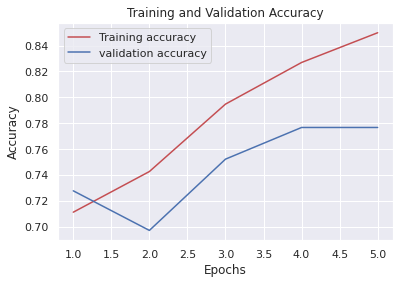

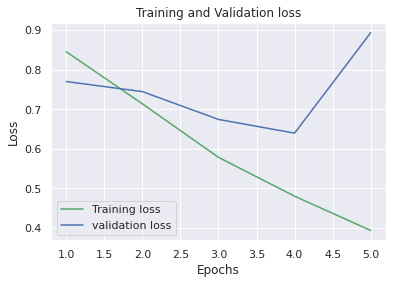

In [ ]:
showacc()
showloss()